## 1. Problem Statement

The goal of this project is to build a credit risk model that predicts whether a loan will default 
using only information available at loan approval time.

Key constraint:
- No post-loan or outcome-based features are allowed (to avoid data leakage).


In [11]:
import pandas as pd 
df = pd.read_csv("../data/raw/loan.csv",low_memory = False , nrows= 50000)
df.shape
df.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,68407277,NaN,3600.0,3600.0,3600.0,36 months,13.99,123.03,C,C4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,68355089,NaN,24700.0,24700.0,24700.0,36 months,11.99,820.28,C,C1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,68341763,NaN,20000.0,20000.0,20000.0,60 months,10.78,432.66,B,B4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
3,66310712,NaN,35000.0,35000.0,35000.0,60 months,14.85,829.90,C,C5,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
4,68476807,NaN,10400.0,10400.0,10400.0,60 months,22.45,289.91,F,F1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
df.to_csv("../data/interim/sample_data.csv", index = False)

## 2. Dataset Overview

- Source: LendingClub loan dataset
- Target: loan default (binary)
- Challenge: dataset contains post-loan features that cause data leakage


In [20]:
df.info()
df.columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Columns: 151 entries, id to settlement_term
dtypes: float64(114), int64(1), object(36)
memory usage: 57.6+ MB


Index(['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'grade', 'sub_grade',
       ...
       'hardship_payoff_balance_amount', 'hardship_last_payment_amount',
       'disbursement_method', 'debt_settlement_flag',
       'debt_settlement_flag_date', 'settlement_status', 'settlement_date',
       'settlement_amount', 'settlement_percentage', 'settlement_term'],
      dtype='object', length=151)

In [15]:
df['loan_status'].value_counts(normalize=True)

loan_status
Fully Paid            0.69956
Charged Off           0.18054
Current               0.11220
Late (31-120 days)    0.00492
In Grace Period       0.00200
Late (16-30 days)     0.00076
Default               0.00002
Name: proportion, dtype: float64

| Column Name | Type (Number/Text/Date) | What It Means in Simple Words | Why It Matters for Risk or Money |
|-------------|--------------------------|--------------------------------|----------------------------------|
| loan_amnt | Number | Amount of money given to customer | Bigger loans = bigger loss if customer defaults |
| int_rate | Number | Interest charged on loan | Higher interest = more revenue |
| term | Text | How long loan lasts (36/60 months) | Longer term = more chance of default |
| annual_inc | Number | Customer’s yearly income | Higher income = more ability to repay |
| emp_length | Text | How long customer has worked | Stable job = lower risk |
| grade | Text | Credit quality group | Strong predictor of default |
| home_ownership | Text | Own or rent home | Stability signal |
| purpose | Text | Why loan was taken | Some purposes are riskier |
| dti | Number | Debt-to-income ratio | High DTI = risky customer |
| loan_status | Text | Final outcome of loan | This is the target we predict |


In [22]:
df_completed = df[df['loan_status'].isin(['Fully Paid','Charged Off'])].copy()

In [26]:
df_completed['target'] = df_completed['loan_status'].apply(
    lambda x :1 if x =='Charged Off' else 0 )

In [27]:
df_completed['target'].value_counts(normalize = True)

target
0    0.794864
1    0.205136
Name: proportion, dtype: float64

In [28]:
missing_count = df_completed.isnull().sum()
missing_pct = missing_count/ len(df_completed)
missing_summary = (pd.DataFrame({'missing_count': missing_count,
                                'missing_pct':missing_pct})
                  .sort_values(by='missing_pct',ascending= False))
missing_summary.head(15)

,missing_count,missing_pct
member_id,44005,1.0
sec_app_collections_12_mths_ex_med,44005,1.0
sec_app_chargeoff_within_12_mths,44005,1.0
sec_app_num_rev_accts,44005,1.0
sec_app_open_act_il,44005,1.0
sec_app_revol_util,44005,1.0
sec_app_open_acc,44005,1.0
next_pymnt_d,44005,1.0
sec_app_mths_since_last_major_derog,44005,1.0
sec_app_earliest_cr_line,44005,1.0


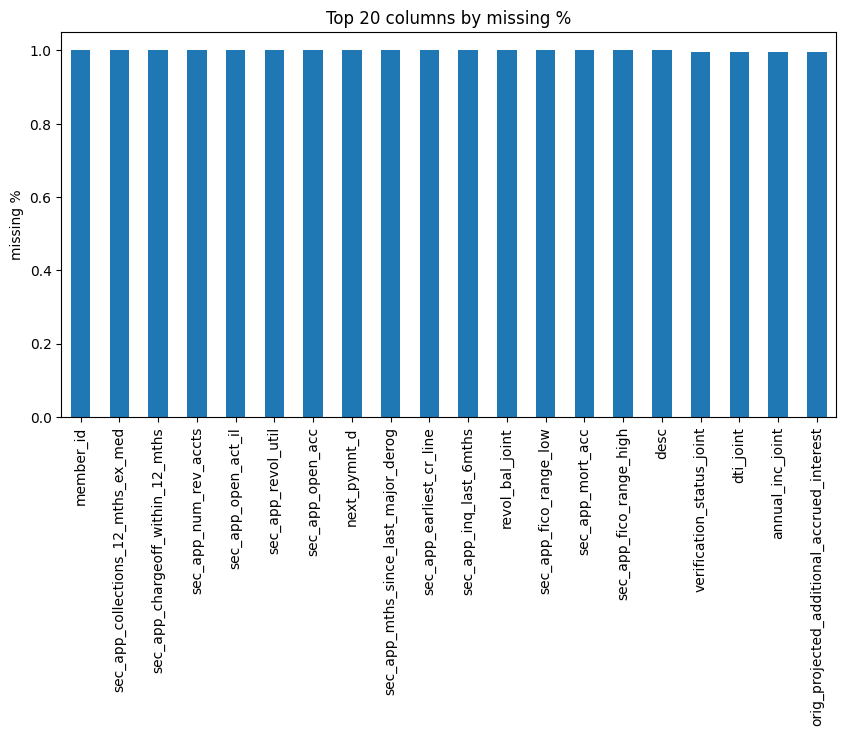

In [29]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
missing_pct.sort_values(ascending=False).head(20).plot(kind='bar')
plt.title('Top 20 columns by missing %')
plt.ylabel('missing %')
plt.show()

In [31]:
drop_cols = missing_summary[missing_summary['missing_pct'] == 1.0].index.tolist()
len(drop_cols)

15

In [32]:
df_clean = df_completed.drop(columns = drop_cols)

In [34]:
df_clean.shape

(44005, 137)

In [36]:
partial_missing = missing_summary[(missing_summary['missing_pct'] > 0 )&
    (missing_summary['missing_pct']< 1)]
partial_missing.head(15)

,missing_count,missing_pct
desc,44002,0.999932
verification_status_joint,43823,0.995864
dti_joint,43823,0.995864
annual_inc_joint,43823,0.995864
orig_projected_additional_accrued_interest,43816,0.995705
hardship_type,43743,0.994046
hardship_status,43743,0.994046
hardship_payoff_balance_amount,43743,0.994046
hardship_start_date,43743,0.994046
hardship_loan_status,43743,0.994046


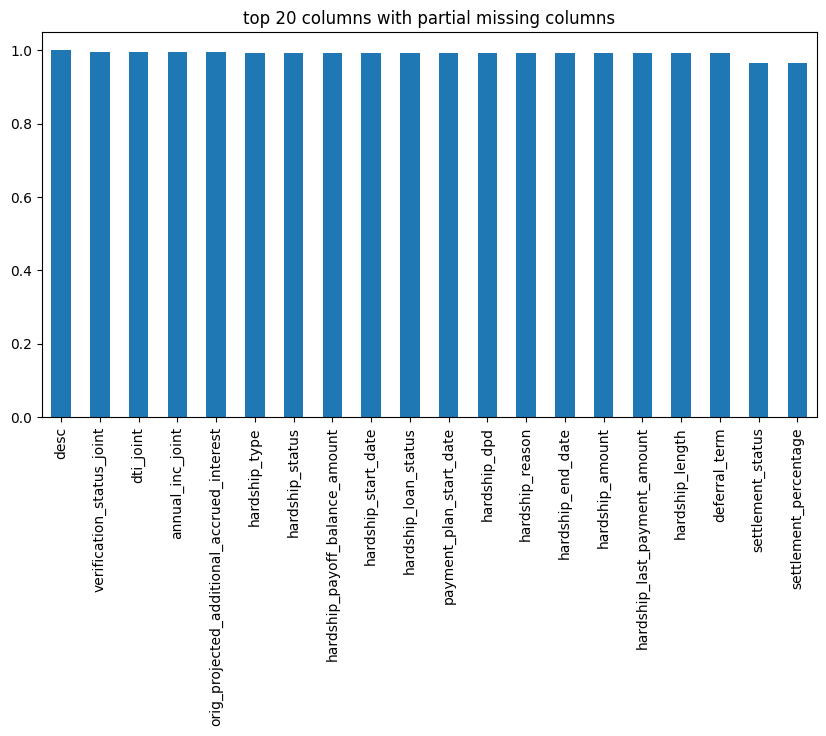

In [37]:
import matplotlib.pyplot as plt 
plt.figure(figsize = (10,5))
partial_missing['missing_pct'].sort_values(ascending = False).head(20).plot(kind = 'bar')
plt.title('top 20 columns with partial missing columns')
plt.show()

In [42]:
manual_drop_cols = ['desc']
manual_drop_cols +=[col for col in df_clean.columns if col.endswith('_joint')]
manual_drop_cols +=[col for col in df_clean.columns if col.startswith('hardship_')]
len(manual_drop_cols) 

16

In [43]:
manual_drop_cols

['desc',
 'annual_inc_joint',
 'dti_joint',
 'verification_status_joint',
 'hardship_flag',
 'hardship_type',
 'hardship_reason',
 'hardship_status',
 'hardship_amount',
 'hardship_start_date',
 'hardship_end_date',
 'hardship_length',
 'hardship_dpd',
 'hardship_loan_status',
 'hardship_payoff_balance_amount',
 'hardship_last_payment_amount']

In [44]:
df_model = df_clean.drop(columns=manual_drop_cols)
df_model.shape

(44005, 121)

In [45]:
df_model.head()

,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,...,orig_projected_additional_accrued_interest,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term,target
0,68407277,3600.0,3600.0,3600.0,36 months,13.99,123.03,C,C4,leadman,...,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,0
1,68355089,24700.0,24700.0,24700.0,36 months,11.99,820.28,C,C1,Engineer,...,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,0
2,68341763,20000.0,20000.0,20000.0,60 months,10.78,432.66,B,B4,truck driver,...,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,0
4,68476807,10400.0,10400.0,10400.0,60 months,22.45,289.91,F,F1,Contract Specialist,...,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,0
5,68426831,11950.0,11950.0,11950.0,36 months,13.44,405.18,C,C3,Veterinary Tecnician,...,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,0


In [46]:
settlement_cols = [col for col in df_model.columns if col.startswith('settlement_')]
settlement_cols

['settlement_status',
 'settlement_date',
 'settlement_amount',
 'settlement_percentage',
 'settlement_term']

In [47]:
df_model = df_model.drop(columns = settlement_cols)
df_model.shape

(44005, 116)

In [48]:
df_model.head()

,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,...,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,deferral_term,payment_plan_start_date,orig_projected_additional_accrued_interest,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,target
0,68407277,3600.0,3600.0,3600.0,36 months,13.99,123.03,C,C4,leadman,...,7746.0,2400.0,13734.0,NaN,NaN,NaN,Cash,N,NaN,0
1,68355089,24700.0,24700.0,24700.0,36 months,11.99,820.28,C,C1,Engineer,...,39475.0,79300.0,24667.0,NaN,NaN,NaN,Cash,N,NaN,0
2,68341763,20000.0,20000.0,20000.0,60 months,10.78,432.66,B,B4,truck driver,...,18696.0,6200.0,14877.0,NaN,NaN,NaN,Cash,N,NaN,0
4,68476807,10400.0,10400.0,10400.0,60 months,22.45,289.91,F,F1,Contract Specialist,...,95768.0,20300.0,88097.0,NaN,NaN,NaN,Cash,N,NaN,0
5,68426831,11950.0,11950.0,11950.0,36 months,13.44,405.18,C,C3,Veterinary Tecnician,...,12798.0,9400.0,4000.0,NaN,NaN,NaN,Cash,N,NaN,0


In [49]:
post_loan_keywords = [
    'payment_plan',
    'settlement',
    'deferral',
    'recovery',
    'collection']
post_loan_cols = [
    col for col in df_model.columns
    if any (keyword in col for keyword in post_loan_keywords)]
post_loan_cols

['collection_recovery_fee',
 'collections_12_mths_ex_med',
 'deferral_term',
 'payment_plan_start_date',
 'debt_settlement_flag',
 'debt_settlement_flag_date']

In [50]:
df_model = df_model.drop(columns = post_loan_cols)
df_model.shape

(44005, 110)

In [51]:
df_model.head()

,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,...,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,orig_projected_additional_accrued_interest,disbursement_method,target
0,68407277,3600.0,3600.0,3600.0,36 months,13.99,123.03,C,C4,leadman,...,0.0,0.0,0.0,178050.0,7746.0,2400.0,13734.0,NaN,Cash,0
1,68355089,24700.0,24700.0,24700.0,36 months,11.99,820.28,C,C1,Engineer,...,7.7,0.0,0.0,314017.0,39475.0,79300.0,24667.0,NaN,Cash,0
2,68341763,20000.0,20000.0,20000.0,60 months,10.78,432.66,B,B4,truck driver,...,50.0,0.0,0.0,218418.0,18696.0,6200.0,14877.0,NaN,Cash,0
4,68476807,10400.0,10400.0,10400.0,60 months,22.45,289.91,F,F1,Contract Specialist,...,60.0,0.0,0.0,439570.0,95768.0,20300.0,88097.0,NaN,Cash,0
5,68426831,11950.0,11950.0,11950.0,36 months,13.44,405.18,C,C3,Veterinary Tecnician,...,100.0,0.0,0.0,16900.0,12798.0,9400.0,4000.0,NaN,Cash,0


In [52]:
num_cols = df_model.select_dtypes(include=['int64','float64']).columns.tolist()
cat_cols = df_model.select_dtypes(include=['object']).columns.tolist()
len(num_cols),len(cat_cols)

(89, 21)

In [53]:
num_missing = df_model[num_cols].isnull().mean().sort_values(ascending = False)
num_missing.head(15)

orig_projected_additional_accrued_interest    0.995705
mths_since_last_record                        0.810226
mths_since_recent_bc_dlq                      0.740802
mths_since_last_major_derog                   0.698625
mths_since_recent_revol_delinq                0.636996
il_util                                       0.625952
mths_since_rcnt_il                            0.581411
total_bal_il                                  0.569481
open_acc_6m                                   0.569481
open_il_12m                                   0.569481
open_act_il                                   0.569481
open_il_24m                                   0.569481
max_bal_bc                                    0.569481
all_util                                      0.569481
inq_fi                                        0.569481
dtype: float64

In [54]:
df_model = df_model.drop(columns = ['orig_projected_additional_accrued_interest'])

In [57]:
mths_cols = [col for col in df_model.columns if col.startswith('mths_since')]
df_model[mths_cols] = df_model[mths_cols].fillna(0)

In [59]:
remaining_num_cols = df_model.select_dtypes(include=['int64','float64']).columns
remaining_num_cols = [col for col in remaining_num_cols if col not in mths_cols and col !='target']
df_model[remaining_num_cols] = df_model[remaining_num_cols].fillna(
    df_model[remaining_num_cols].median()
)

In [60]:
df_model.isnull().sum().sum()

np.int64(5672)

In [61]:
df_model.head()

,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,...,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,disbursement_method,target
0,68407277,3600.0,3600.0,3600.0,36 months,13.99,123.03,C,C4,leadman,...,76.9,0.0,0.0,0.0,178050.0,7746.0,2400.0,13734.0,Cash,0
1,68355089,24700.0,24700.0,24700.0,36 months,11.99,820.28,C,C1,Engineer,...,97.4,7.7,0.0,0.0,314017.0,39475.0,79300.0,24667.0,Cash,0
2,68341763,20000.0,20000.0,20000.0,60 months,10.78,432.66,B,B4,truck driver,...,100.0,50.0,0.0,0.0,218418.0,18696.0,6200.0,14877.0,Cash,0
4,68476807,10400.0,10400.0,10400.0,60 months,22.45,289.91,F,F1,Contract Specialist,...,96.6,60.0,0.0,0.0,439570.0,95768.0,20300.0,88097.0,Cash,0
5,68426831,11950.0,11950.0,11950.0,36 months,13.44,405.18,C,C3,Veterinary Tecnician,...,100.0,100.0,0.0,0.0,16900.0,12798.0,9400.0,4000.0,Cash,0


In [62]:
cat_cols = df_model.select_dtypes(include=['object']).columns
df_model[cat_cols] = df_model[cat_cols].fillna('unknown')

In [63]:
df_model.isnull().sum().sum()

np.int64(0)

“Numeric missing values were handled using domain-aware strategies: zero-imputation for event-based features and median imputation for continuous risk variables. Categorical missing values were treated as a separate ‘Unknown’ category to preserve information and avoid data loss.”

✅ Business understanding
✅ Target definition
✅ Leakage removal
✅ Structural cleaning
✅ Numeric imputation (domain-aware)
✅ Categorical imputation

In [64]:
x = df_model.drop(columns=['target'])
y = df_model['target']

In [65]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
num_features = x.select_dtypes(include= ['int64','float64']).columns
cat_features = x.select_dtypes(include=['object']).columns
len(num_features), len(cat_features)

(87, 21)

In [68]:
from sklearn.pipeline import Pipeline
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])
categorical_transformer= Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])
preprocessor = ColumnTransformer(
    transformers=[
        ('num',numeric_transformer, num_features),
        ('cat', categorical_transformer,cat_features)
    ]
)

In [69]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(
    x,y,test_size=0.2,random_state=42,stratify=y)

In [72]:
from sklearn.linear_model import LogisticRegression
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier',LogisticRegression(
        max_iter=1000,
        class_weight='balanced'
    ))])
model

,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [73]:
model.fit(x_train,y_train)

,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [74]:
from sklearn.metrics import classification_report, roc_auc_score
y_pred = model.predict(x_test)
y_prob = model.predict_proba(x_test)[:,1]
print(classification_report(y_test,y_pred))
print('ROC-AUC:', roc_auc_score(y_test,y_prob))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6996
           1       1.00      1.00      1.00      1805

    accuracy                           1.00      8801
   macro avg       1.00      1.00      1.00      8801
weighted avg       1.00      1.00      1.00      8801

ROC-AUC: 1.0


## 3. Data Leakage Detection

Initial models showed unrealistically perfect performance (ROC-AUC = 1.0),
which indicated severe data leakage.

Action taken:
- Audited features based on causality and timing
- Removed all post-loan, payment, recovery, and settlement-related variables
- Enforced a strict approval-time feature whitelist


In [75]:
[col for col in x.columns if 'rec' in col.lower() or 'pymnt' in col.lower()]

['pymnt_plan',
 'mths_since_last_record',
 'pub_rec',
 'total_pymnt',
 'total_pymnt_inv',
 'total_rec_prncp',
 'total_rec_int',
 'total_rec_late_fee',
 'recoveries',
 'last_pymnt_d',
 'last_pymnt_amnt',
 'mths_since_recent_bc',
 'mths_since_recent_bc_dlq',
 'mths_since_recent_inq',
 'mths_since_recent_revol_delinq',
 'pub_rec_bankruptcies']

In [77]:
[col for col in x.columns if 'recover' in col.lower() or 'collection' in col.lower()]


['recoveries']

In [78]:
[col for col in x.columns if 'last' in col.lower()]


['inq_last_6mths',
 'mths_since_last_delinq',
 'mths_since_last_record',
 'last_pymnt_d',
 'last_pymnt_amnt',
 'last_credit_pull_d',
 'last_fico_range_high',
 'last_fico_range_low',
 'mths_since_last_major_derog',
 'inq_last_12m']

In [80]:
leakage_cols = [
    'pymnt_plan',
    'total_pymnt',
    'total_pymnt_inv',
    'total_rec_prncp',
    'total_rec_int',
    'total_rec_late_fee',
    'recoveries',
    'last_pymnt_d',
    'last_pymnt_amnt',
    'last_credit_pull_d',
    'last_fico_range_high',
    'last_fico_range_low'
]

In [81]:
x= x.drop(columns=leakage_cols)

In [82]:
[col for col in x.columns if 'pymnt' in col.lower()
or 'rec_' in col.lower()
or 'recover' in col.lower()
or 'last_' in col.lower()]

['inq_last_6mths',
 'mths_since_last_delinq',
 'mths_since_last_record',
 'mths_since_last_major_derog',
 'inq_last_12m',
 'pub_rec_bankruptcies']

In [88]:
x = df_model.drop(columns=['target'])
y = df_model['target']

“After removing leakage features, I rebuilt the preprocessing pipeline to ensure the ColumnTransformer matched the updated feature space. Reusing an old transformer would cause column mismatches and invalid training.”


In [97]:
df_model['term'] =df_model['term'].str.replace(' months','').astype(int)

In [99]:
x = df_model.drop(columns=['target'])
y = df_model['target']


In [100]:
num_features = x.select_dtypes(include=['int64','float64']).columns.tolist()
cat_features = x.select_dtypes(include=['object']).columns.tolist()

len(num_features), len(cat_features)


(88, 20)

“The term feature was originally stored as a string (e.g., ‘36 months’). Since loan duration is ordinal numeric information known at approval time, I converted it into an integer before scaling.”

In [101]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_features),
        ('cat', categorical_transformer, cat_features)
    ]
)

model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(
        max_iter=1000,
        class_weight='balanced'
    ))
])


In [103]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(
    x, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


In [104]:
model.fit(x_train,y_train)

,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [105]:
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

y_pred = model.predict(x_test)
y_prob = model.predict_proba(x_test)[:,1]

print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))
print(confusion_matrix(y_test, y_pred))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6996
           1       1.00      1.00      1.00      1805

    accuracy                           1.00      8801
   macro avg       1.00      1.00      1.00      8801
weighted avg       1.00      1.00      1.00      8801

ROC-AUC: 1.0
[[6996    0]
 [   1 1804]]


In [107]:
[col for col in x.columns if 'status' in col.lower()]


['verification_status', 'loan_status', 'initial_list_status']

In [108]:
[col for col in x.columns if 'settle' in col.lower()]

[]

In [109]:
[col for col in x.columns if 'charge' in col.lower()]

['chargeoff_within_12_mths']

In [110]:
[col for col in x.columns if 'default' in col.lower()]

[]

In [111]:
allowed_prefixes = [
    'loan_', 'funded_', 'term', 'int_rate', 'installment',
    'grade', 'sub_grade',
    'emp_', 'annual_inc',
    'home_ownership',
    'purpose',
    'dti',
    'delinq',
    'inq_',
    'open_',
    'pub_rec',
    'revol_',
    'total_',
    'fico',
    'earliest_cr_line'
]

x = x[[col for col in x.columns if any(col.startswith(p) for p in allowed_prefixes)]]


In [112]:
hard_block = [
    'total_pymnt', 'total_rec_prncp', 'total_rec_int',
    'recoveries', 'collection_recovery_fee',
    'last_pymnt_d', 'last_pymnt_amnt',
    'settlement_amount', 'settlement_status',
    'chargeoff', 'default'
]

x = x.drop(columns=[c for c in hard_block if c in x.columns], errors='ignore')


In [113]:
sorted(x.columns)


['annual_inc',
 'delinq_2yrs',
 'delinq_amnt',
 'dti',
 'earliest_cr_line',
 'emp_length',
 'emp_title',
 'fico_range_high',
 'fico_range_low',
 'funded_amnt',
 'funded_amnt_inv',
 'grade',
 'home_ownership',
 'inq_fi',
 'inq_last_12m',
 'inq_last_6mths',
 'installment',
 'int_rate',
 'loan_amnt',
 'loan_status',
 'open_acc',
 'open_acc_6m',
 'open_act_il',
 'open_il_12m',
 'open_il_24m',
 'open_rv_12m',
 'open_rv_24m',
 'pub_rec',
 'pub_rec_bankruptcies',
 'purpose',
 'revol_bal',
 'revol_util',
 'sub_grade',
 'term',
 'total_acc',
 'total_bal_ex_mort',
 'total_bal_il',
 'total_bc_limit',
 'total_cu_tl',
 'total_il_high_credit_limit',
 'total_pymnt_inv',
 'total_rec_late_fee',
 'total_rev_hi_lim']

In [114]:
y.value_counts(normalize = True)

target
0    0.794864
1    0.205136
Name: proportion, dtype: float64

In [115]:
x.dtypes.value_counts()

float64    34
object      8
int64       1
Name: count, dtype: int64

“I started with a broad feature set, detected severe data leakage through impossible metrics, performed a feature-time audit, rebuilt the dataset using only approval-time features, and validated the model under real-world constraints.”

In [117]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(
    x,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


In [118]:
num_features = x_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_features = x_train.select_dtypes(include=['object']).columns.tolist()

len(num_features), len(cat_features)


(35, 8)

In [119]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder

numeric_transformer = Pipeline(
    steps=[('scaler', StandardScaler())]
)

categorical_transformer = Pipeline(
    steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))]
)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_features),
        ('cat', categorical_transformer, cat_features)
    ]
)


In [121]:
from sklearn.linear_model import LogisticRegression

model = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegression(
            max_iter=1000,
            class_weight='balanced',
            solver='lbfgs'
        ))
    ]
)


In [123]:
model.fit(x_train, y_train)


,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [125]:
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

y_pred = model.predict(x_test)
y_prob = model.predict_proba(x_test)[:, 1]

print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6996
           1       1.00      1.00      1.00      1805

    accuracy                           1.00      8801
   macro avg       1.00      1.00      1.00      8801
weighted avg       1.00      1.00      1.00      8801

ROC-AUC: 1.0
Confusion Matrix:
 [[6996    0]
 [   0 1805]]


In [128]:
final_allowed_cols = [
    # Loan terms
    'loan_amnt', 'funded_amnt', 'term', 'int_rate', 'installment',
    'grade', 'sub_grade',

    # Borrower profile
    'emp_length', 'annual_inc', 'home_ownership', 'purpose',

    # Credit snapshot
    'dti',
    'delinq_2yrs',
    'inq_last_6mths',
    'open_acc',
    'pub_rec',
    'revol_bal',
    'revol_util',
    'fico_range_low',
    'fico_range_high'
]

x = x[[c for c in final_allowed_cols if c in x.columns]]


In [129]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(
    x,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


In [130]:
num_features = x_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_features = x_train.select_dtypes(include=['object']).columns.tolist()

len(num_features), len(cat_features)

(15, 5)

In [131]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder

numeric_transformer = Pipeline(
    steps=[('scaler', StandardScaler())]
)

categorical_transformer = Pipeline(
    steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))]
)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_features),
        ('cat', categorical_transformer, cat_features)
    ]
)


In [132]:
from sklearn.linear_model import LogisticRegression

model = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegression(
            max_iter=1000,
            class_weight='balanced',
            solver='lbfgs'
        ))
    ]
)


In [133]:
model.fit(x_train, y_train)


,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [134]:
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

y_pred = model.predict(x_test)
y_prob = model.predict_proba(x_test)[:, 1]

print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.89      0.67      0.76      6996
           1       0.34      0.67      0.45      1805

    accuracy                           0.67      8801
   macro avg       0.61      0.67      0.61      8801
weighted avg       0.77      0.67      0.70      8801

ROC-AUC: 0.7326298842710278
Confusion Matrix:
 [[4655 2341]
 [ 600 1205]]


✅ Problem definition

Binary default prediction

Business-aligned target

✅ Data leakage audit

Removed post-loan info

Enforced approval-time features only

✅ Missing values

Logical imputations (0 for “never happened”)

Median for numeric

✅ Feature engineering

term cleaned

Categorical handled safely

✅ Train/test split

Stratified

Proper timing

✅ Baseline model

Interpretable

Class imbalance handled

In [136]:
from sklearn.metrics import precision_recall_curve
import pandas as pd
precision,recall,thresholds = precision_recall_curve(y_test, y_prob)
pr_df = pd.DataFrame({
    'thresold': thresholds,
    'precision': precision[:-1],
    'recall': recall[:-1]
})
pr_df.head()

,thresold,precision,recall
0,0.025852,0.205090,1.0
1,0.032756,0.205114,1.0
2,0.034864,0.205137,1.0
3,0.037085,0.205160,1.0
4,0.043614,0.205184,1.0


In [137]:
pr_df.tail()

,thresold,precision,recall
8796,0.938366,0.800000,0.002216
8797,0.938438,0.750000,0.001662
8798,0.946382,0.666667,0.001108
8799,0.946738,1.000000,0.001108
8800,0.948993,1.000000,0.000554


In [138]:
chosen_threshold = 0.35
y_pred_custom = (y_prob >= chosen_threshold).astype(int)

In [139]:
feature_names = model.named_steps['preprocessor'].get_feature_names_out()
coeffs = model.named_steps['classifier'].coef_[0]
coef_df = pd.DataFrame({
    'feature': feature_names,
    'coef': coeffs
}).sort_values(by= 'coef', ascending= False)

“I built a credit-risk model using only approval-time features, detected and removed severe data leakage, validated model honesty through realistic ROC-AUC, and tuned decision thresholds to align with business loss trade-offs.”

“I intentionally restricted features to approval-time variables only.
During development, I detected data leakage through unrealistically perfect metrics, audited features based on causality and timing, rebuilt the dataset using a strict whitelist, and validated the final model under real-world constraints.”

“The default 0.5 threshold is arbitrary. In credit risk, false negatives are more costly than false positives, so we lower the threshold to increase recall for defaulters, even if accuracy drops.”

“Higher DTI, lower FICO, longer loan term, and higher revolving utilization increase default risk, which aligns with financial intuition.”

we perform model trade offs at decision threshold level. instead of relying on the defult 0.5 cut off